#### Imports

In [1]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
import time
from transformers import DistilBertTokenizer, DistilBertModel
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from hyperopt import hp
from scipy.stats import kruskal
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova,FeatureSelectionDiversityPursuitKruskal
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))


GPU Available: False
Number of GPU Available: 0


In [34]:
models_dir = "c:/transformer_models/"
if os.path.isdir(models_dir) is not True:
    os.mkdir(models_dir)

## Load the dataset

#### IMDB dataset

In [3]:
imdb = load_dataset("imdb")

Found cached dataset imdb (C:/Users/rgolan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# embed the sentences - take 500 negative samples and 500 positive samples. Note that in the IMDB set, the negative examples are in the first half of the dataset (0-12500)
# the positive examples are in the second half
num_sentences_to_embed = 1000
neg_examples_idx = list(np.random.randint(low=0,high=12500,size=num_sentences_to_embed//2))
pos_examples_idx = list(np.random.randint(low=12500,high=25000,size=num_sentences_to_embed//2))
examples_to_embed_idx = neg_examples_idx + pos_examples_idx

In [5]:
train_sentences = [imdb['train'][int(i)]['text'] for i in examples_to_embed_idx]
train_labels = [imdb['train'][int(i)]['label'] for i in examples_to_embed_idx]
print(f"there are {len(train_sentences)} sentences in the training set")

there are 1000 sentences in the training set


#### AG-News dataset

In [65]:
ag_news_ds = load_dataset("ag_news")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to C:/Users/rgolan/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [70]:
num_sentences_to_embed = 2000
all_labels = np.array([ag_news_ds['train'][int(i)]['label'] for i in range(len(ag_news_ds['train']))])
all_idx = np.arange(len(ag_news_ds['train']))
train_idx, test_idx, train_labels, test_labels = train_test_split(all_idx, all_labels, train_size=num_sentences_to_embed, stratify=all_labels)

In [79]:
train_sentences = [ag_news_ds['train'][int(train_idx[i])]['text'] for i in range(train_idx.shape[0])]

In [84]:
i = 1000
print(train_sentences[i], train_labels[i])

Rapper practices with USC football team USC #39;s football team may be in the hunt for one of the two coveted spots in the national championship game, but that doesn #39;t mean the Trojans aren #39;t trying to enjoy the ride to a possible Orange Bowl berth. 1


## Get embeddings

#### BERT embeddings

In [86]:
# initialize a tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir=models_dir)

In [87]:
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-uncased", cache_dir=models_dir)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [88]:
embed_dim = bert_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")
bert_model.config.output_hidden_states = True

embedding dimension = 768


In [89]:
bert_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = bert_tokenizer(train_sentences[i], padding=True, truncation=True, max_length=256, return_tensors="pt")
    with torch.no_grad():
        output = bert_model(**input)
    # as the sentence embedding we're taking the hidden state corresponding to the [CLS] token
    bert_embeddings[i,:] = output.last_hidden_state[:,0,:].numpy()
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


processed 101 sentences
so far, 7.3177 seconds passed 


processed 201 sentences
so far, 16.6009 seconds passed 


processed 301 sentences
so far, 25.5561 seconds passed 


processed 401 sentences
so far, 34.7508 seconds passed 


processed 501 sentences
so far, 43.7885 seconds passed 


processed 601 sentences
so far, 55.2849 seconds passed 


processed 701 sentences
so far, 65.9478 seconds passed 


processed 801 sentences
so far, 77.1241 seconds passed 


processed 901 sentences
so far, 88.5237 seconds passed 


processed 1001 sentences
so far, 98.0746 seconds passed 


processed 1101 sentences
so far, 107.0748 seconds passed 


processed 1201 sentences
so far, 116.4722 seconds passed 


processed 1301 sentences
so far, 125.5085 seconds passed 


processed 1401 sentences
so far, 134.5890 seconds passed 


processed 1501 sentences
so far, 143.4401 seconds passed 


processed 1601 sentences
so far, 152.9872 seconds passed 


processed 1701 sentences
so far, 165.2777 seconds passed 




In [90]:
print(f"bert embeddings shape = {bert_embeddings.shape}")

bert embeddings shape = (2000, 768)


#### GPT2 embeddings

In [95]:
from transformers import AutoTokenizer, GPT2Model
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2", cache_dir=models_dir)
gpt2_model = GPT2Model.from_pretrained("gpt2", cache_dir=models_dir)

In [96]:
embed_dim = gpt2_model.config.n_embd
print(f"embedding dimension = {embed_dim}")
gpt2_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = gpt2_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = gpt2_model(**input)
    # with GPT2 embeddings, we take the mean of the hidden states of all tokens
    gpt2_embeddings[i,:] = output.last_hidden_state[:,:,:].numpy().mean(axis=1)
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


embedding dimension = 768
processed 101 sentences
so far, 7.9885 seconds passed 


processed 201 sentences
so far, 16.8382 seconds passed 


processed 301 sentences
so far, 28.4606 seconds passed 


processed 401 sentences
so far, 40.0196 seconds passed 


processed 501 sentences
so far, 51.9748 seconds passed 


processed 601 sentences
so far, 63.1657 seconds passed 


processed 701 sentences
so far, 71.9059 seconds passed 


processed 801 sentences
so far, 80.9971 seconds passed 


processed 901 sentences
so far, 90.0706 seconds passed 


processed 1001 sentences
so far, 99.3141 seconds passed 


processed 1101 sentences
so far, 110.6163 seconds passed 


processed 1201 sentences
so far, 123.6310 seconds passed 


processed 1301 sentences
so far, 134.7704 seconds passed 


processed 1401 sentences
so far, 145.3974 seconds passed 


processed 1501 sentences
so far, 155.5846 seconds passed 


processed 1601 sentences
so far, 166.5421 seconds passed 


processed 1701 sentences
so far, 1

#### XLNet embeddings

In [97]:
from transformers import XLNetModel

xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased", cache_dir=models_dir)
xlnet_model = XLNetModel.from_pretrained("xlnet-base-cased", cache_dir=models_dir)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
embed_dim = xlnet_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")

embedding dimension = 768


In [99]:
xlnet_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = xlnet_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = xlnet_model(**input)
    xlnet_embeddings[i,:] = output.last_hidden_state[:,-1,:].numpy()
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")

processed 101 sentences
so far, 12.0105 seconds passed 


processed 201 sentences
so far, 26.4010 seconds passed 


processed 301 sentences
so far, 40.1186 seconds passed 


processed 401 sentences
so far, 55.2785 seconds passed 


processed 501 sentences
so far, 71.2471 seconds passed 


processed 601 sentences
so far, 87.2732 seconds passed 


processed 701 sentences
so far, 102.7303 seconds passed 


processed 801 sentences
so far, 118.7175 seconds passed 


processed 901 sentences
so far, 134.8441 seconds passed 


processed 1001 sentences
so far, 150.3874 seconds passed 


processed 1101 sentences
so far, 165.7539 seconds passed 


processed 1201 sentences
so far, 182.3115 seconds passed 


processed 1301 sentences
so far, 200.1680 seconds passed 


processed 1401 sentences
so far, 216.1688 seconds passed 


processed 1501 sentences
so far, 229.9443 seconds passed 


processed 1601 sentences
so far, 244.3036 seconds passed 


processed 1701 sentences
so far, 258.5122 seconds passe

#### BART embeddings

In [100]:
from transformers import AutoTokenizer, BartModel

bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", cache_dir=models_dir)
bart_model = BartModel.from_pretrained("facebook/bart-base", cache_dir=models_dir)
embed_dim = bart_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")

embedding dimension = 768


In [101]:
bart_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = bart_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = bart_model(**input)
    bart_embeddings[i,:] = output.last_hidden_state[:,:,:].numpy().mean(axis=1)
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


processed 101 sentences
so far, 10.2391 seconds passed 


processed 201 sentences
so far, 21.4842 seconds passed 


processed 301 sentences
so far, 32.1924 seconds passed 


processed 401 sentences
so far, 42.8739 seconds passed 


processed 501 sentences
so far, 53.8737 seconds passed 


processed 601 sentences
so far, 65.4924 seconds passed 


processed 701 sentences
so far, 76.1972 seconds passed 


processed 801 sentences
so far, 87.5240 seconds passed 


processed 901 sentences
so far, 99.0505 seconds passed 


processed 1001 sentences
so far, 110.3832 seconds passed 


processed 1101 sentences
so far, 121.9233 seconds passed 


processed 1201 sentences
so far, 134.0412 seconds passed 


processed 1301 sentences
so far, 145.4446 seconds passed 


processed 1401 sentences
so far, 156.5131 seconds passed 


processed 1501 sentences
so far, 168.2182 seconds passed 


processed 1601 sentences
so far, 179.7756 seconds passed 


processed 1701 sentences
so far, 192.6344 seconds passed 


## Classification of embedded test

In [123]:
embed_list = [bart_embeddings,bert_embeddings,xlnet_embeddings]
X = np.concatenate(embed_list,axis=1)
print(f"X shape = {X.shape}")

X shape = (2000, 2304)


In [124]:
y = np.array(train_labels)

In [125]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}

hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=X, y_train=y, iterations=50)
best_params = hyper_opt.run()
print(f"best_params = {best_params}")

100%|██████████| 50/50 [08:55<00:00, 10.72s/trial, best loss: -0.8905]           
best_params = {'C': 3.370121667332815, 'degree': 3, 'kernel': 'rbf'}


Measuring accuracy with 4 classes,  5 training examples per class
---------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.43244444444444446, std accuracy is 0.03478145507861885
classifier cs_fs_dp, mean accuracy is 0.6836565656565656, std accuracy is 0.1127519686210202
classifier cs_fs_ova, mean accuracy is 0.641909090909091, std accuracy is 0.14444898241088033
classifier knn_cls, mean accuracy is 0.43594949494949503, std accuracy is 0.05565479566013545
classifier knn_fs_dp, mean accuracy is 0.6323737373737373, std accuracy is 0.11996076502078928
classifier knn_fs_ova, mean accuracy is 0.584010101010101, std accuracy is 0.12333133172872587
classifier svm, mean accuracy is 0.5784040404040404, std accuracy is 0.0552732552104269




Measuring accuracy with 4 classes,  10 training examples per class
---------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.43926530612244896, std accuracy is 0.03248216

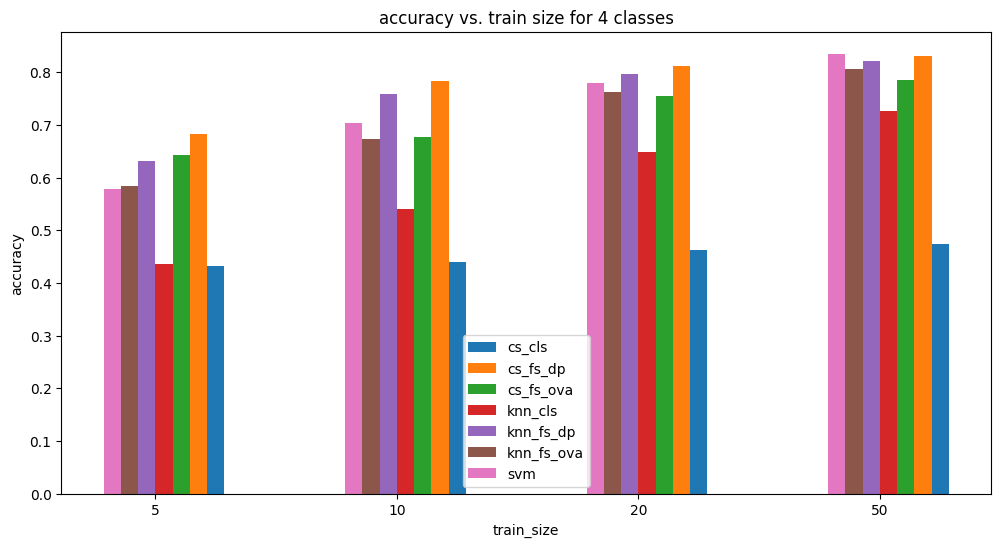

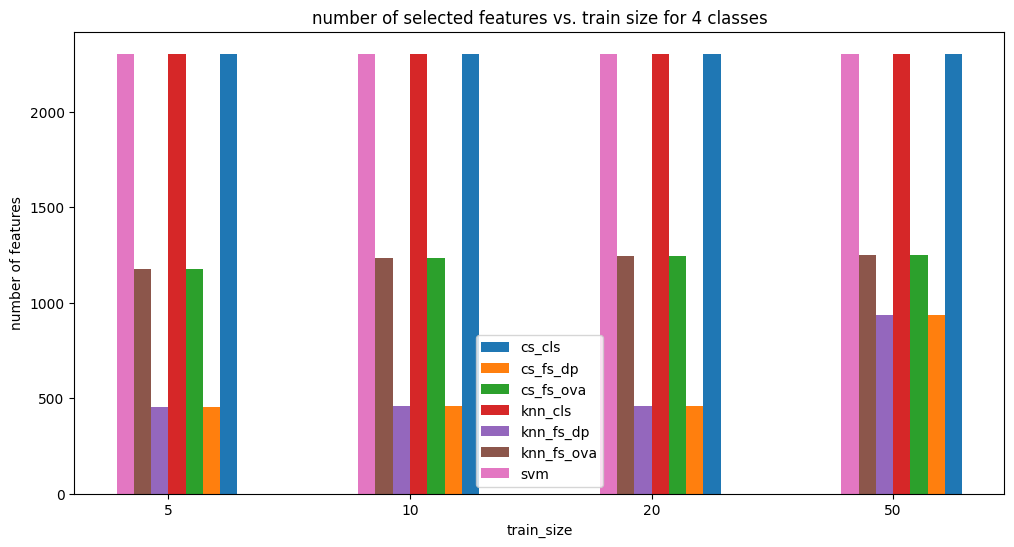

In [126]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova
gamma = 0.2
train_sizes = [5,10,20,50]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(), dp_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
num_experiments = 50
num_splits = 5
# define possible sizes for the train set (number of train examples per class)
num_classes = 4
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    print(f"Measuring accuracy with {num_classes} classes,  {train_sizes[i]} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_sizes[i]*num_classes, stratify=y)
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers,
                                                                                              X_train=X_train,
                                                                                              y_train=y_train,
                                                                                              X_test=X_test,
                                                                                              y_test=y_test)
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.mean(accuracies[l,i,:])}, std accuracy is {np.std(accuracies[l,i,:])}")
    print("\n\n\n")

bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')